In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from utilsCPD import *
import matplotlib.pyplot as plt
from SWCPD import BaseDetector as SWDCP

3.314188913929866
2.7577336840194557
-0.12510049802071965
3.6242689142994995
2.2581175274030603
-0.8001097026060632


<Axes: >

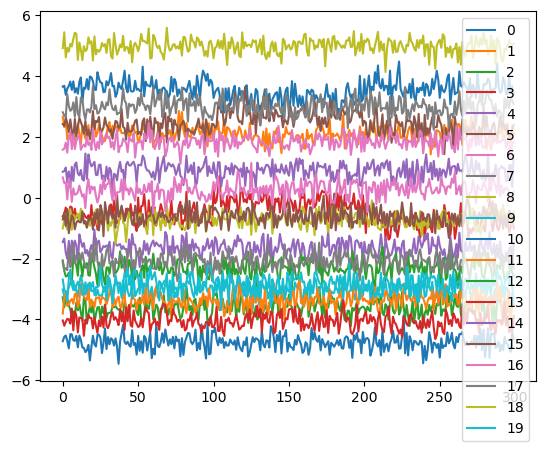

In [2]:
def make_dynamic_blobs(n_samples, base_center, n_clusters, varying_features, 
                       cluster_std=1.0, center_offset_range=(-5, 5), random_state=None):
    """
    Generate synthetic data with dynamic centers based on a base center and random offsets.
    
    Parameters:
        n_samples: int
            Total number of samples.
        base_center: array-like
            The center of the first cluster. Shape: (n_features,).
        n_clusters: int
            Number of clusters to generate.
        varying_features: list of int
            Indices of features that should vary across clusters.
        cluster_std: float
            Standard deviation of clusters.
        center_offset_range: tuple
            Range (min, max) for random uniform offsets added to the base center for varying features.
        random_state: int or None
            Random seed for reproducibility.
    
    Returns:
        X: ndarray of shape (n_samples, n_features)
            The generated samples.
        y: ndarray of shape (n_samples,)
            The integer labels for cluster membership.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n_features = len(base_center)
    samples_per_cluster = n_samples // n_clusters
    remainder = n_samples % n_clusters

    # Generate cluster centers
    centers = [np.array(base_center,dtype=float)]
    for _ in range(1, n_clusters):
        new_center = centers[0].copy()  # Start with the base center
        for feature in varying_features:
        
            new_center[feature] +=  np.random.uniform(*center_offset_range)
            print(new_center[feature])
            
        centers.append(new_center)
    centers = np.array(centers)
    
    # Generate points for each cluster
    X = []
    y = []
    for cluster_idx, center in enumerate(centers):
        cluster_size = samples_per_cluster + (1 if cluster_idx < remainder else 0)
        cluster_points = np.random.normal(
            loc=center,
            scale=cluster_std,
            size=(cluster_size, n_features)
        )
        X.append(cluster_points)
        y.extend([cluster_idx] * cluster_size)
    
    X = np.vstack(X)
    y = np.array(y)
    
    return X.astype(np.float32), y, centers

# Example Usage
base_center = list(np.random.uniform(-5,5,20))#,0,0,0,0]  # Base center for the first cluster
n_clusters = 3
n_samples = 300
varying_features = [0,5,3]#[0,5,3]#, 1,4,5,6]  # Only the first two features vary
X, y, centers = make_dynamic_blobs(
    n_samples=n_samples, 
    base_center=base_center, 
    n_clusters=n_clusters, 
    varying_features=varying_features, 
    cluster_std=0.25, 
    center_offset_range=(-0.5, 0.5), 
    random_state=2025
)

fig, ax = plt.subplots()
pd.DataFrame(X).plot(ax=ax,legend=True)


##for Plot swd_exp
#base_center = list(np.random.uniform(-5,5,10))#,0,0,0,0]  # Base center for the first cluster
# n_clusters = 3
# n_samples = 1500
# varying_features = [0,5,3]#, 1,4,5,6]  # Only the first two features vary
# X, y, centers = make_dynamic_blobs(
#     n_samples=n_samples, 
#     base_center=base_center, 
#     n_clusters=n_clusters, 
#     varying_features=varying_features, 
#     cluster_std=0.2, 
#     center_offset_range=(-2, 2), 
#     random_state=2025
#)

In [83]:
#detection_delay(set(detector.change_points['loc']),set(GroundTruth))
def detection_delay(gt, pred):
    """Compute detection delay for each predicted CP.
    
    Args:
        T (set): Ground truth CPs (annotations).
        X (set): Predicted CPs.

    Returns:
        delays (dict): {prediction: detection delay}
        avg_delay (float): Mean detection delay
    """
    T = set(gt)
    X = set(pred)
    delays = {}
    for x in X:
        if T:  # Ensure T is not empty
            closest_t = min(T, key=lambda t: abs(x - t))  # Find closest annotation
            delays[x] = abs(x - closest_t)  # Compute delay
    
    avg_delay = np.mean(list(delays.values())) if delays else 0  # Mean delay
    return delays, avg_delay


def f_measure(annotations, predictions, margin=5, alpha=0.5, return_PR=False):
    """Compute the F-measure based on human annotations.

    annotations : dict from user_id to iterable of CP locations
    predictions : iterable of predicted CP locations
    alpha : value for the F-measure, alpha=0.5 gives the F1-measure
    return_PR : whether to return precision and recall too

    Remember that all CP locations are 0-based!

    >>> f_measure({1: [10, 20], 2: [11, 20], 3: [10], 4: [0, 5]}, [10, 20])
    1.0
    >>> f_measure({1: [], 2: [10], 3: [50]}, [10])
    0.9090909090909091
    >>> f_measure({1: [], 2: [10], 3: [50]}, [])
    0.8
    """
    # ensure 0 is in all the sets
    Tks = {k + 1: set(annotations[uid]) for k, uid in enumerate(annotations)}
    for Tk in Tks.values():
        Tk.add(0)

    X = set(predictions)
    X.add(0)

    Tstar = set()
    for Tk in Tks.values():
        for tau in Tk:
            Tstar.add(tau)

    K = len(Tks)

    P = len(true_positives(Tstar, X, margin=margin)) / len(X)

    TPk = {k: true_positives(Tks[k], X, margin=margin) for k in Tks}
    R = 1 / K * sum(len(TPk[k]) / len(Tks[k]) for k in Tks)

    TP = false_positives(Tstar,X,margin=margin)
    F = P * R / (alpha * R + (1 - alpha) * P)
    if return_PR:
        return F, P, R
    return F, auc([0,R,1.0],[1.0,P,0]),len(false_positives(Tstar,X,margin=margin))



def true_positives(T, X, margin=5):
    """Compute true positives without double counting

    >>> true_positives({1, 10, 20, 23}, {3, 8, 20})
    {1, 10, 20}
    >>> true_positives({1, 10, 20, 23}, {1, 3, 8, 20})
    {1, 10, 20}
    >>> true_positives({1, 10, 20, 23}, {1, 3, 5, 8, 20})
    {1, 10, 20}
    >>> true_positives(set(), {1, 2, 3})
    set()
    >>> true_positives({1, 2, 3}, set())
    set()
    """
    # make a copy so we don't affect the caller
    X = set(list(X))
    TP = set()
    for tau in T:
        close = [(abs(tau - x), x) for x in X if abs(tau - x) <= margin]
        close.sort()
        if not close:
            continue
        dist, xstar = close[0]
        TP.add(tau)
        X.remove(xstar)
    return TP

# def false_positives(T, X, margin=5):
#     """Returns a set of false positives (incorrectly predicted CPs)."""
#     TP = true_positives(T, X, margin)
#     return X - TP  # FP = All Predictions - True Positives
def false_positives(T, X, margin=5):
    """Compute false positives (predictions that don't match any true CPs within margin)."""
    FP = set()
    for x in X:
        if not any(abs(x - t) <= margin for t in T):  # No match within margin
            FP.add(x)
    return FP

In [ ]:
METRICS_SWD = {}
for id,i in enumerate(range(1)):
    print(id)
    METRICS_SWD[id]  = {}
    df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
    print(GroundTruth)
    #100-100
    #50-50 for ExpPLot 
    detector = SWDCP(data=df,window_length=50,max_history=50,significance=0.05)
    print(detector.device)
    detector.process_dataloader(p=4,n_theta=5000,explanations=False,exp_param={'num_features_to_remove':3,'max_parameter':True,"q":0.95})
    METRICS_SWD[id]['F1 & AUC & FP'] =f_measure({'0':GroundTruth},detector.change_points['loc'],margin=20)
    METRICS_SWD[id]['DD']  = detection_delay(GroundTruth,detector.change_points['loc'])[1]
    METRICS_SWD[id]['Covering'] = covering({'0':GroundTruth},detector.change_points['loc'],n_obs=df.shape[0])
    print(METRICS_SWD[id])

0
[100 200]
cpu


 36%|███▌      | 90/251 [00:00<00:01, 123.90it/s]

Change detected at: 118 
Initiate new segment


 73%|███████▎  | 184/251 [00:01<00:00, 132.65it/s]

Change detected at: 215 
Initiate new segment


100%|██████████| 251/251 [00:01<00:00, 126.83it/s]


{'F1 & AUC & FP': (1.0, 1.0, 0), 'DD': 16.5, 'Covering': 0.8035003684598379}


### Vary $\sigma$, $\delta$ 

In [150]:
base_center = list(np.random.uniform(-5,5,20))#,0,0,0,0]  # Base center for the first cluster

In [41]:
#base_center = list(np.random.uniform(-5,5,20))#,0,0,0,0]  # Base center for the first cluster

random_states = [2020,2021,2022,2023,2024]#,2021,2022,2023,2024,2025]
n_clusters = 3
n_samples = 1500
varying_features = [0,5,3]

SIGMA = [0.1,0.5,1]

METRICS = []
#METRICS[rs] = {}
RUN_STATS = {}
for sigma in SIGMA:
    RUN_STATS[str(sigma)] = {'F1 & AUC & FP':[],'Covering':[],'DD':[]}
    for rs in random_states:
        print(rs,sigma)
        #RUN_STATS[sigma] = {}
        X, y, centers = make_dynamic_blobs(
            n_samples=n_samples, 
            base_center=base_center, 
            n_clusters=n_clusters, 
            varying_features=varying_features, 
            cluster_std=sigma, 
            center_offset_range=(-3, 3), 
            random_state=rs
        )
        df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
        print(GroundTruth)
        detector = SWDCP(data=df,window_length=50,max_history=50,significance=0.05)
        print(detector.device)
        detector.process_dataloader(p=2,n_theta=5000,explanations=False)
        TMP = {}
        for margin in [5,10,20]:
            TMP[str(margin)] = f_measure({'0':GroundTruth},detector.change_points['loc'],margin=margin)
        RUN_STATS[str(sigma)]['F1 & AUC & FP'].append(TMP)
        RUN_STATS[str(sigma)]['DD'].append(detection_delay(GroundTruth,detector.change_points['loc'])[1])
        RUN_STATS[str(sigma)]['Covering'].append(covering({'0':GroundTruth},detector.change_points['loc'],n_obs=df.shape[0]))
        #print(RUN_STATS)
    #METRICS.append(RUN_STATS)
RUN_STATS

2020 0.1
6.6355378780285506
5.982635571666704
-2.6131299731792472
2.3488911905514125
2.7637962632185578
-4.369877532907191
[ 500 1000]
cpu


 33%|███▎      | 472/1451 [00:03<00:07, 139.69it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 975/1451 [00:07<00:03, 139.94it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 139.45it/s]


2021 0.1
4.353746577703387
5.142500063903766
-4.837920182638344
2.5939154079870796
6.725743584784689
-4.902628870494972
[ 500 1000]
cpu


 33%|███▎      | 479/1451 [00:03<00:06, 142.16it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 977/1451 [00:06<00:03, 147.60it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 143.76it/s]


2022 0.1
0.774028587705546
3.7366307618547046
-4.991300983399726
1.0177210139247408
4.854729462201327
-2.7496747137143545
[ 500 1000]
cpu


 33%|███▎      | 478/1451 [00:03<00:06, 148.42it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 976/1451 [00:06<00:03, 145.94it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:09<00:00, 147.13it/s]


2023 0.1
2.6498067288107645
6.0848186074796615
-2.143289590305894
1.4774534658847056
1.5903312321918905
-2.8642295693595416
[ 500 1000]
cpu


 32%|███▏      | 466/1451 [00:03<00:06, 147.64it/s]

Change detected at: 501 
Initiate new segment


 68%|██████▊   | 980/1451 [00:06<00:03, 147.08it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 144.88it/s]


2024 0.1
4.245964018231345
4.936936382832272
-4.542691362777701
0.9807282873401468
1.9723976111085093
-5.035225876151142
[ 500 1000]
cpu


 32%|███▏      | 470/1451 [00:03<00:06, 148.90it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 977/1451 [00:06<00:03, 142.54it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:09<00:00, 145.46it/s]


2020 0.5
6.6355378780285506
5.982635571666704
-2.6131299731792472
2.3488911905514125
2.7637962632185578
-4.369877532907191
[ 500 1000]
cpu


 33%|███▎      | 475/1451 [00:03<00:06, 144.58it/s]

Change detected at: 504 
Initiate new segment


 67%|██████▋   | 970/1451 [00:06<00:03, 144.50it/s]

Change detected at: 1003 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 141.83it/s]


2021 0.5
4.353746577703387
5.142500063903766
-4.837920182638344
2.5939154079870796
6.725743584784689
-4.902628870494972
[ 500 1000]
cpu


 33%|███▎      | 475/1451 [00:03<00:06, 141.52it/s]

Change detected at: 509 
Initiate new segment


 68%|██████▊   | 984/1451 [00:06<00:03, 143.10it/s]

Change detected at: 1010 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 142.68it/s]


2022 0.5
0.774028587705546
3.7366307618547046
-4.991300983399726
1.0177210139247408
4.854729462201327
-2.7496747137143545
[ 500 1000]
cpu


 33%|███▎      | 474/1451 [00:03<00:06, 140.10it/s]

Change detected at: 507 
Initiate new segment


 69%|██████▊   | 995/1451 [00:07<00:03, 146.83it/s]

Change detected at: 1016 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 141.46it/s]


2023 0.5
2.6498067288107645
6.0848186074796615
-2.143289590305894
1.4774534658847056
1.5903312321918905
-2.8642295693595416
[ 500 1000]
cpu


 33%|███▎      | 478/1451 [00:03<00:06, 140.62it/s]

Change detected at: 509 
Initiate new segment


 67%|██████▋   | 970/1451 [00:06<00:03, 143.18it/s]

Change detected at: 1005 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 141.84it/s]


2024 0.5
4.245964018231345
4.936936382832272
-4.542691362777701
0.9807282873401468
1.9723976111085093
-5.035225876151142
[ 500 1000]
cpu


 33%|███▎      | 485/1451 [00:03<00:06, 141.58it/s]

Change detected at: 512 
Initiate new segment


 67%|██████▋   | 978/1451 [00:06<00:03, 141.64it/s]

Change detected at: 1005 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 141.28it/s]


2020 1
6.6355378780285506
5.982635571666704
-2.6131299731792472
2.3488911905514125
2.7637962632185578
-4.369877532907191
[ 500 1000]
cpu


 33%|███▎      | 482/1451 [00:03<00:06, 145.93it/s]

Change detected at: 513 
Initiate new segment


 68%|██████▊   | 981/1451 [00:06<00:03, 130.66it/s]

Change detected at: 1007 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 137.32it/s]


2021 1
4.353746577703387
5.142500063903766
-4.837920182638344
2.5939154079870796
6.725743584784689
-4.902628870494972
[ 500 1000]
cpu


 33%|███▎      | 485/1451 [00:03<00:07, 132.49it/s]

Change detected at: 519 
Initiate new segment
Change detected at: 531 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 131.42it/s]


2022 1
0.774028587705546
3.7366307618547046
-4.991300983399726
1.0177210139247408
4.854729462201327
-2.7496747137143545
[ 500 1000]
cpu


 33%|███▎      | 479/1451 [00:03<00:07, 129.43it/s]

Change detected at: 515 
Initiate new segment
Change detected at: 519 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 131.67it/s]


2023 1
2.6498067288107645
6.0848186074796615
-2.143289590305894
1.4774534658847056
1.5903312321918905
-2.8642295693595416
[ 500 1000]
cpu


 35%|███▍      | 501/1451 [00:03<00:06, 146.66it/s]

Change detected at: 525 
Initiate new segment


 68%|██████▊   | 988/1451 [00:07<00:03, 140.68it/s]

Change detected at: 1010 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 138.95it/s]


2024 1
4.245964018231345
4.936936382832272
-4.542691362777701
0.9807282873401468
1.9723976111085093
-5.035225876151142
[ 500 1000]
cpu


 68%|██████▊   | 989/1451 [00:06<00:03, 144.37it/s]

Change detected at: 1018 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 142.26it/s]


{'0.1': {'F1 & AUC & FP': [{'5': (1.0, 1.0, 0),
    '10': (1.0, 1.0, 0),
    '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)}],
  'Covering': [0.9973373253493014,
   0.9973373253493014,
   0.9973373253493014,
   0.9973373253493014,
   0.9973373253493014],
  'DD': [1.0, 1.0, 1.0, 1.0, 1.0]},
 '0.5': {'F1 & AUC & FP': [{'5': (1.0, 1.0, 0),
    '10': (1.0, 1.0, 0),
    '20': (1.0, 1.0, 0)},
   {'5': (0.3333333333333333, 0.3333333333333333, 2),
    '10': (1.0, 1.0, 0),
    '20': (1.0, 1.0, 0)},
   {'5': (0.3333333333333333, 0.3333333333333333, 2),
    '10': (0.6666666666666666, 0.6666666666666666, 1),
    '20': (1.0, 1.0, 0)},
   {'5': (0.6666666666666666, 0.6666666666666666, 1),
    '10': (1.0, 1.0, 0),
    '20': (1.0, 1.0, 0)},
   {'5': (0.666666666666

In [53]:
RUN_STATS['0.1']['F1 & AUC & FP']

grouped = {}

for d in RUN_STATS['0.1']['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[2])  # Append the value to the corresponding key

print(0.1,pd.DataFrame(grouped).describe())


for d in RUN_STATS['0.5']['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[2])  # Append the value to the corresponding key

print(0.5,pd.DataFrame(grouped).describe())



for d in RUN_STATS['1']['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[2])  # Append the value to the corresponding key

print(1,pd.DataFrame(grouped).describe())

0.1          5   10   20
count  5.0  5.0  5.0
mean   0.0  0.0  0.0
std    0.0  0.0  0.0
min    0.0  0.0  0.0
25%    0.0  0.0  0.0
50%    0.0  0.0  0.0
75%    0.0  0.0  0.0
max    0.0  0.0  0.0
0.5                5         10    20
count  10.000000  10.000000  10.0
mean    0.600000   0.200000   0.0
std     0.843274   0.421637   0.0
min     0.000000   0.000000   0.0
25%     0.000000   0.000000   0.0
50%     0.000000   0.000000   0.0
75%     1.000000   0.000000   0.0
max     2.000000   1.000000   0.0
1               5         10         20
count  15.00000  15.000000  15.000000
mean    1.00000   0.600000   0.133333
std     0.92582   0.736788   0.351866
min     0.00000   0.000000   0.000000
25%     0.00000   0.000000   0.000000
50%     1.00000   0.000000   0.000000
75%     2.00000   1.000000   0.000000
max     2.00000   2.000000   1.000000


In [91]:
print(0.1,np.mean(RUN_STATS['0.1']['DD']),np.min(RUN_STATS['0.1']['DD']),np.max(RUN_STATS['0.1']['DD']))
print(0.5,np.mean(RUN_STATS['0.5']['DD']),np.min(RUN_STATS['0.5']['DD']),np.max(RUN_STATS['0.5']['DD']))
print(1,np.mean(RUN_STATS['1']['DD']),np.min(RUN_STATS['1']['DD']),np.max(RUN_STATS['1']['DD']))

0.1 1.0 1.0 1.0
0.5 8.0 3.5 11.5
1 9.847826086956522 1.5 25.0


## False positives

| $\sigma^{2}$ | $\tau=5$ | $\tau=10$ | $\tau=20$ |
|-------------|----------|-----------|-----------|
| 0.1         | 0.0 (0;0)  | 0.0 (0;0)  | 0.0 (0;0)  |
| 0.5         | 0.6 (0;2) | 0.2 (0;1) | 0.0 (0;0)  |
| 1.0         | 1.0 (0;2) | 0.6 (0;2) | 0.13 (0;1) |

## Detection Delay

| $\sigma^{2}$ |DD (min;max)|
|-------------|----------|
| 0.1         | 1.0 (1;1)| 
| 0.5         | 8.0 (3.5;11.5) | 
| 1.0         | 9.84 (1.5;25) |

### Severity $\delta$

In [87]:
#base_center = list(np.random.uniform(-5,5,20))#,0,0,0,0]  # Base center for the first cluster

random_states = [2020,2021,2022,2023,2024]#,2021,2022,2023,2024,2025]
n_clusters = 3
n_samples = 1500
varying_features = [0,5,3]

SEVIRITY = [(-1,1),(-2,2),(-3,3)]

METRICS_SEVERITY = []
#METRICS[rs] = {}
RUN_STATS_SEVERITY = {}
for drift_range in SEVIRITY:
    RUN_STATS_SEVERITY[str(drift_range[1])] = {'F1 & AUC & FP':[],'Covering':[],'DD':[]}
    for rs in random_states:
        print(rs,sigma) 
        #RUN_STATS[sigma] = {}
        X, y, centers = make_dynamic_blobs(
            n_samples=n_samples, 
            base_center=base_center, 
            n_clusters=n_clusters, 
            varying_features=varying_features, 
            cluster_std=0.25, 
            center_offset_range=drift_range, 
            random_state=rs
        )
        df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
        print(GroundTruth)
        detector = SWDCP(data=df,window_length=50,max_history=50,significance=0.05)
        print(detector.device)
        detector.process_dataloader(p=2,n_theta=5000,explanations=False)
        TMP = {}
        for margin in [5,10,20]:
            TMP[str(margin)] = f_measure({'0':GroundTruth},detector.change_points['loc'],margin=margin)
        RUN_STATS_SEVERITY[str(drift_range[1])]['F1 & AUC & FP'].append(TMP)
        RUN_STATS_SEVERITY[str(drift_range[1])]['DD'].append(detection_delay(GroundTruth,detector.change_points['loc'])[1])
        RUN_STATS_SEVERITY[str(drift_range[1])]['Covering'].append(covering({'0':GroundTruth},detector.change_points['loc'],n_obs=df.shape[0]))
        #print(RUN_STATS)
    #METRICS.append(RUN_STATS)
RUN_STATS_SEVERITY


2020 1
4.690430562582156
4.4890677883840855
-2.652112073065574
3.2615483334231095
3.4161213522347036
-3.237694592974888
[ 500 1000]
cpu


 33%|███▎      | 481/1451 [00:03<00:07, 136.19it/s]

Change detected at: 508 
Initiate new segment


 67%|██████▋   | 974/1451 [00:07<00:03, 138.65it/s]

Change detected at: 1005 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 138.02it/s]


2021 1
3.929833462473767
4.209022619129772
-3.3937088095519394
3.343223072568332
4.736770459423414
-3.4152783721708153
[ 500 1000]
cpu


 34%|███▎      | 489/1451 [00:03<00:06, 139.55it/s]

Change detected at: 515 
Initiate new segment


 68%|██████▊   | 989/1451 [00:07<00:03, 132.10it/s]

Change detected at: 1019 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 137.33it/s]


2022 1
2.7365941324744876
3.7403995184467522
-3.444835743139066
2.817824941214219
4.11309908522896
-2.697626986577276
[ 500 1000]
cpu


 33%|███▎      | 480/1451 [00:03<00:06, 149.17it/s]

Change detected at: 512 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 142.56it/s]


2023 1
3.3618535128428935
4.523128800321738
-2.495498612107789
2.97106909186754
3.0249663418924815
-2.7358119384590047
[ 500 1000]
cpu


 33%|███▎      | 476/1451 [00:03<00:07, 135.09it/s]

Change detected at: 514 
Initiate new segment
Change detected at: 517 
Initiate new segment


 68%|██████▊   | 982/1451 [00:06<00:03, 146.09it/s]

Change detected at: 1008 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 140.96it/s]


2024 1
3.893905942649754
4.140501392105941
-3.2952992029317247
2.8054940323526876
3.152321801531354
-3.4594773740562053
[ 500 1000]
cpu


 34%|███▍      | 491/1451 [00:03<00:06, 141.01it/s]

Change detected at: 518 
Initiate new segment


 68%|██████▊   | 989/1451 [00:07<00:03, 139.48it/s]

Change detected at: 1009 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 140.72it/s]


2020 1
5.662984220305353
5.2358516800253945
-2.6326210231224105
2.805219761987261
3.0899588077266307
-3.8037860629410396
[ 500 1000]
cpu


 32%|███▏      | 467/1451 [00:03<00:07, 138.16it/s]

Change detected at: 503 
Initiate new segment


 67%|██████▋   | 969/1451 [00:07<00:03, 136.12it/s]

Change detected at: 1002 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 137.71it/s]


2021 1
4.141790020088576
4.675761341516769
-4.115814496095142
2.9685692402777057
5.731257022104051
-4.158953621332894
[ 500 1000]
cpu


 33%|███▎      | 482/1451 [00:03<00:07, 137.51it/s]

Change detected at: 505 
Initiate new segment


 67%|██████▋   | 976/1451 [00:06<00:03, 140.57it/s]

Change detected at: 1007 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 141.89it/s]


2022 1
1.7553113600900168
3.7385151401507284
-4.218068363269396
1.9177729775694798
4.483914273715143
-2.723650850145815
[ 500 1000]
cpu


 33%|███▎      | 481/1451 [00:03<00:06, 143.52it/s]

Change detected at: 505 
Initiate new segment


 68%|██████▊   | 982/1451 [00:07<00:03, 138.61it/s]

Change detected at: 1010 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 139.57it/s]


2023 1
3.005830120826829
5.3039737039006996
-2.3193941012068415
2.224261278876123
2.307648787042186
-2.800020753909273
[ 500 1000]
cpu


 33%|███▎      | 483/1451 [00:03<00:06, 139.53it/s]

Change detected at: 506 
Initiate new segment


 67%|██████▋   | 970/1451 [00:06<00:03, 142.42it/s]

Change detected at: 1003 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 140.12it/s]


2024 1
4.06993498044055
4.5387188874691065
-3.9189952828547128
1.8931111598464172
2.5623597063199317
-4.247351625103674
[ 500 1000]
cpu


 33%|███▎      | 480/1451 [00:03<00:06, 143.43it/s]

Change detected at: 509 
Initiate new segment


 68%|██████▊   | 984/1451 [00:07<00:03, 142.24it/s]

Change detected at: 1003 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 139.51it/s]


2020 1
6.6355378780285506
5.982635571666704
-2.6131299731792472
2.3488911905514125
2.7637962632185578
-4.369877532907191
[ 500 1000]
cpu


 33%|███▎      | 482/1451 [00:03<00:06, 147.03it/s]

Change detected at: 502 
Initiate new segment


 66%|██████▋   | 964/1451 [00:06<00:03, 144.71it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 144.37it/s]


2021 1
4.353746577703387
5.142500063903766
-4.837920182638344
2.5939154079870796
6.725743584784689
-4.902628870494972
[ 500 1000]
cpu


 33%|███▎      | 481/1451 [00:03<00:06, 146.89it/s]

Change detected at: 503 
Initiate new segment


 68%|██████▊   | 980/1451 [00:06<00:03, 144.50it/s]

Change detected at: 1004 
Initiate new segment


100%|██████████| 1451/1451 [00:09<00:00, 145.14it/s]


2022 1
0.774028587705546
3.7366307618547046
-4.991300983399726
1.0177210139247408
4.854729462201327
-2.7496747137143545
[ 500 1000]
cpu


 33%|███▎      | 481/1451 [00:03<00:06, 145.67it/s]

Change detected at: 503 
Initiate new segment


 68%|██████▊   | 980/1451 [00:06<00:03, 144.56it/s]

Change detected at: 1005 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 144.45it/s]


2023 1
2.6498067288107645
6.0848186074796615
-2.143289590305894
1.4774534658847056
1.5903312321918905
-2.8642295693595416
[ 500 1000]
cpu


 33%|███▎      | 481/1451 [00:03<00:06, 145.55it/s]

Change detected at: 503 
Initiate new segment


 68%|██████▊   | 983/1451 [00:06<00:03, 147.31it/s]

Change detected at: 1002 
Initiate new segment


100%|██████████| 1451/1451 [00:09<00:00, 145.41it/s]


2024 1
4.245964018231345
4.936936382832272
-4.542691362777701
0.9807282873401468
1.9723976111085093
-5.035225876151142
[ 500 1000]
cpu


 33%|███▎      | 479/1451 [00:03<00:06, 146.56it/s]

Change detected at: 505 
Initiate new segment


 67%|██████▋   | 975/1451 [00:06<00:03, 142.96it/s]

Change detected at: 1002 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 143.77it/s]


{'1': {'F1 & AUC & FP': [{'5': (0.6666666666666666, 0.6666666666666666, 1),
    '10': (1.0, 1.0, 0),
    '20': (1.0, 1.0, 0)},
   {'5': (0.3333333333333333, 0.3333333333333333, 2),
    '10': (0.3333333333333333, 0.3333333333333333, 2),
    '20': (1.0, 1.0, 0)},
   {'5': (0.4, 0.4166666666666667, 1),
    '10': (0.4, 0.4166666666666667, 1),
    '20': (0.8, 0.8333333333333333, 0)},
   {'5': (0.28571428571428575, 0.29166666666666663, 3),
    '10': (0.5714285714285715, 0.5833333333333334, 2),
    '20': (0.8571428571428571, 0.875, 0)},
   {'5': (0.3333333333333333, 0.3333333333333333, 2),
    '10': (0.6666666666666666, 0.6666666666666666, 1),
    '20': (1.0, 1.0, 0)}],
  'Covering': [0.9828364647488371,
   0.9557877297017541,
   0.6568784581646424,
   0.9691833491630667,
   0.9647352595368313],
  'DD': [6.5, 17.0, 12.0, 13.0, 13.5]},
 '2': {'F1 & AUC & FP': [{'5': (1.0, 1.0, 0),
    '10': (1.0, 1.0, 0),
    '20': (1.0, 1.0, 0)},
   {'5': (0.6666666666666666, 0.6666666666666666, 1),
    '10':

In [85]:
grouped = {}

for d in RUN_STATS_SEVERITY['1']['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[2])  # Append the value to the corresponding key

print(1,pd.DataFrame(grouped).describe())


for d in RUN_STATS_SEVERITY['2']['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[2])  # Append the value to the corresponding key

print(2,pd.DataFrame(grouped).describe())



for d in RUN_STATS_SEVERITY['3']['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[2])  # Append the value to the corresponding key

print(3,pd.DataFrame(grouped).describe())

1              5       10   20
count  5.00000  5.00000  5.0
mean   1.80000  1.20000  0.0
std    0.83666  0.83666  0.0
min    1.00000  0.00000  0.0
25%    1.00000  1.00000  0.0
50%    2.00000  1.00000  0.0
75%    2.00000  2.00000  0.0
max    3.00000  2.00000  0.0
2                5         10    20
count  10.000000  10.000000  10.0
mean    1.300000   0.600000   0.0
std     0.823273   0.843274   0.0
min     0.000000   0.000000   0.0
25%     1.000000   0.000000   0.0
50%     1.000000   0.000000   0.0
75%     1.750000   1.000000   0.0
max     3.000000   2.000000   0.0
3                5         10    20
count  15.000000  15.000000  15.0
mean    0.866667   0.400000   0.0
std     0.915475   0.736788   0.0
min     0.000000   0.000000   0.0
25%     0.000000   0.000000   0.0
50%     1.000000   0.000000   0.0
75%     1.000000   0.500000   0.0
max     3.000000   2.000000   0.0


In [90]:
print(1,np.mean(RUN_STATS_SEVERITY['1']['DD']),np.min(RUN_STATS_SEVERITY['1']['DD']),np.max(RUN_STATS_SEVERITY['1']['DD']))
print(2,np.mean(RUN_STATS_SEVERITY['2']['DD']),np.min(RUN_STATS_SEVERITY['2']['DD']),np.max(RUN_STATS_SEVERITY['2']['DD']))
print(3,np.mean(RUN_STATS_SEVERITY['3']['DD']),np.min(RUN_STATS_SEVERITY['3']['DD']),np.max(RUN_STATS_SEVERITY['3']['DD']))

1 12.4 6.5 17.0
2 5.3 2.5 7.5
3 3.0 1.5 4.0


## False positives

| $\|\delta\|$ | $\tau=5$ | $\tau=10$ | $\tau=20$ |
|-------------|----------|-----------|-----------|
| 1         | 1.8 (1;3)  | 1.2 (0;2)  | 0.0 (0;0)|
| 2         | 1.3 (0;3) | 0.6 (0;2) | 0.0  (0;0)  |
| 3         | 0.87 (0;3) | 0.4 (0;2) | 0.0 (0;0) |

## Detection Delay

| $\|\delta\|$ |DD (min;max)|
|-------------|----------|
| 1         | 12.4 (6.5;17) | 
| 2         | 5.3 (2.5;7.5) | 
| 3         | 3.0 (1.5;4.0) |

In [3]:
base_center = list(np.random.uniform(-5,5,10))#,0,0,0,0]  # Base center for the first cluster
n_clusters = 3
n_samples = 1500
varying_features = [0,5,3]#, 1,4,5,6]  # Only the first two features vary
X, y, centers = make_dynamic_blobs(
    n_samples=n_samples, 
    base_center=base_center, 
    n_clusters=n_clusters, 
    varying_features=varying_features, 
    cluster_std=0.2, 
    center_offset_range=(-2, 2), 
    random_state=2025
)

METRICS_SWD = {}
for id,i in enumerate(range(1)):
    print(id)
    METRICS_SWD[id]  = {}
    df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
    print(GroundTruth)
    #100-100
    #50-50 for ExpPLot 
    detector = SWDCP(data=df,window_length=50,max_history=50,significance=0.01)
    print(detector.device)
    detector.process_dataloader(p=4,n_theta=5000,explanations=True,exp_param={'num_features_to_remove':3,'max_parameter':True,"q":0.95})
    METRICS_SWD[id]['F1'] =f_measure({'0':GroundTruth},detector.change_points['loc'],margin=20)
    METRICS_SWD[id]['Covering'] = covering({'0':GroundTruth},detector.change_points['loc'],n_obs=df.shape[0])
    print(METRICS_SWD[id])

-4.982519262608445
0.4774643132459677
6.306837407817222
-3.7421992611299113
-1.5210003132196137
3.606800589475847
0
[ 500 1000]
cpu


 32%|███▏      | 459/1451 [00:03<00:09, 107.20it/s]

Change detected at: 501 
Initiate new segment
SWD: 0.012159904465079308
SWD: 0.004655004944652319
SWD: 0.0007574399933218956
([{'removed_feature': 0, 'contribution_value': 0.6638122, 'beta': 9.407106, 'alpha': 0.11438951484144828}, {'removed_feature': 3, 'contribution_value': 0.7892077, 'beta': 25.416307, 'alpha': 0.11831304089787249}, {'removed_feature': 5, 'contribution_value': 0.8045846, 'beta': 174.59706, 'alpha': 0.1322467934619834}], [array([0.6638122 , 0.10223835, 0.0536137 , 0.42500094, 0.13407692,
       0.53433913, 0.09306253, 0.03952881, 0.19467781, 0.11740021],
      dtype=float32), array([0.09895861, 0.11680824, 0.2002121 , 0.7892077 , 0.07033966,
       0.35844082, 0.2110063 , 0.35129088, 0.10137294, 0.04468117],
      dtype=float32), array([0.03565508, 0.4348684 , 0.0690281 , 0.11111222, 0.24288778,
       0.8045846 , 0.05312908, 0.00210612, 0.2754881 , 0.08623007],
      dtype=float32)])
SWD: 0.012159904465079308
SWD: 0.004655004944652319
SWD: 0.0007574399933218956


 66%|██████▌   | 959/1451 [00:07<00:04, 106.59it/s]

Change detected at: 1001 
Initiate new segment
SWD: 0.0244798231869936
SWD: 0.004369156900793314
SWD: 0.0002077433600788936
([{'removed_feature': 3, 'contribution_value': 0.7320223, 'beta': 5.1706324, 'alpha': 0.12657616387000356}, {'removed_feature': 5, 'contribution_value': 0.8221435, 'beta': 28.298744, 'alpha': 0.12364165724530653}, {'removed_feature': 0, 'contribution_value': 0.74671584, 'beta': 1041.4397, 'alpha': 0.21635218674452736}], [array([0.3406381 , 0.04540036, 0.18816686, 0.7320223 , 0.06914604,
       0.3804653 , 0.25584033, 0.2510892 , 0.03335107, 0.1774645 ],
      dtype=float32), array([0.19726144, 0.09850094, 0.11240613, 0.2343148 , 0.11272236,
       0.8221435 , 0.24557562, 0.18488684, 0.12099419, 0.29341164],
      dtype=float32), array([0.74671584, 0.18537644, 0.28979886, 0.06775334, 0.42315271,
       0.08831827, 0.0084305 , 0.02489855, 0.2709119 , 0.24193951],
      dtype=float32)])
SWD: 0.0244798231869936
SWD: 0.004369156900793314
SWD: 0.0002077433600788936


100%|██████████| 1451/1451 [00:11<00:00, 121.26it/s]

{'F1': (1.0, 1.0, 0), 'Covering': 0.9973373253493014}


### Explainability Plot

[0.6638122  0.21797167 0.10761797 0.7892077  0.14910145 0.8045846
 0.11906597 0.13097528 0.19051296 0.08277048]
[0.6638122  0.21797167 0.10761797 0.7892077  0.14910145 0.8045846
 0.11906597 0.13097528 0.19051296 0.08277048]
['blue', 'gray', 'gray', 'black', 'gray', 'green', 'gray', 'gray', 'gray', 'gray']
[0.74671584 0.10975925 0.19679062 0.7320223  0.2016737  0.8221435
 0.16994882 0.15362486 0.14175238 0.23760521]


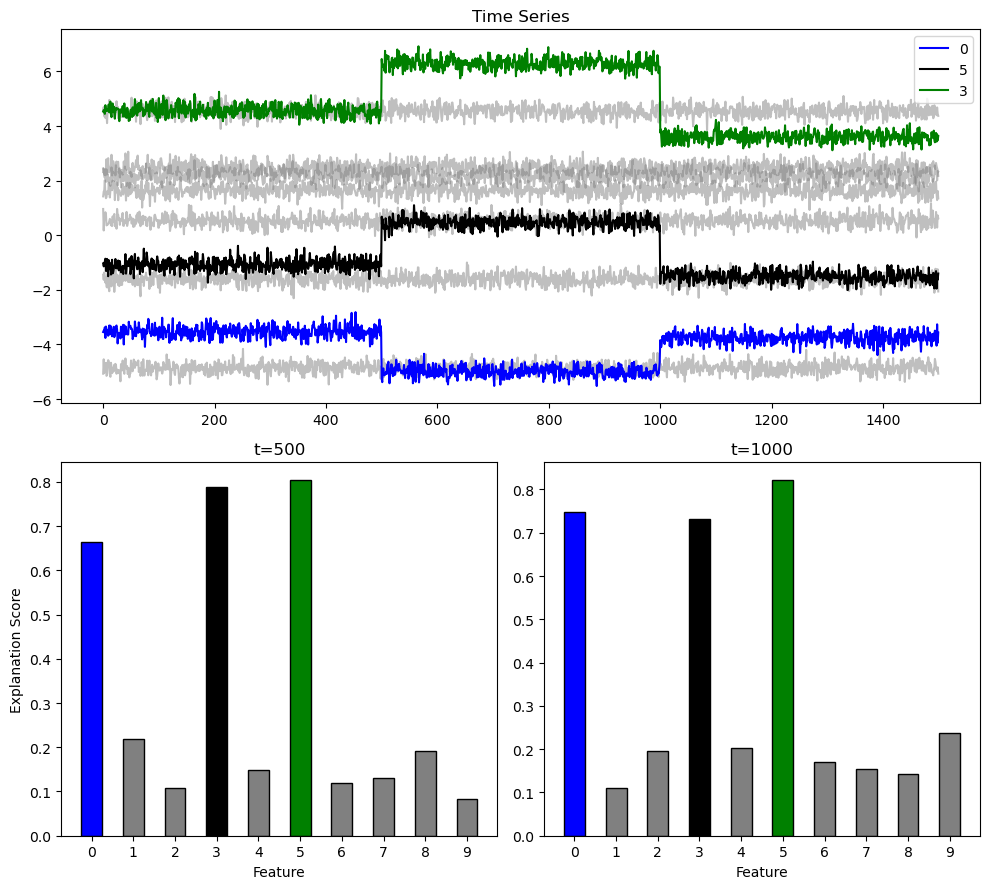

In [4]:
from matplotlib.gridspec import GridSpec


Contributions_plot = np.vstack(detector.exp_data[0][1]).mean(axis=0)
for data in zip(detector.exp_data[0][0],detector.exp_data[0][1]):
    d,c = data[0], data[1]
    Contributions_plot[d['removed_feature']] = c[d['removed_feature']]

print(Contributions_plot)

fig = plt.figure(figsize=(10,9))
gs = GridSpec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax1.set_title('Time Series')
#pd.DataFrame(X).iloc[:,varying_features].plot(ax=ax1,color=['blue','black','green'])
columns_to_select = [i for i in range(X.shape[1]) if i not in varying_features]
pd.DataFrame(X).iloc[:,columns_to_select].plot(ax=ax1,color='gray',alpha=0.5,legend=False)
pd.DataFrame(X).iloc[:,varying_features].plot(ax=ax1,color=['blue','black','green'])



Contributions_plot = np.vstack(detector.exp_data[0][1]).mean(axis=0)
for data in zip(detector.exp_data[0][0],detector.exp_data[0][1]):
    d,c = data[0], data[1]
    Contributions_plot[d['removed_feature']] = c[d['removed_feature']]

print(Contributions_plot)

# color_bars = []
# color_bars = [
#     'blue' if i in varying_features else 'gray' 
#     for i in range(Contributions_plot.shape[0])
# ]
c =0
color_bars = []
color_drifts = ['blue','black','green']
for i in range(Contributions_plot.shape[0]):
    if i in varying_features:
        color_bars.append(color_drifts[c])
        c+=1
    else:
        color_bars.append('gray')

print(color_bars)

ax2 = fig.add_subplot(gs[1, 0])

# Plot the bar chart
ax2.bar(
    x=pd.DataFrame(Contributions_plot).index,
    height=pd.DataFrame(Contributions_plot)[0],
    width = 0.5,
    color=color_bars,
    edgecolor='black'
)
ax2.set_xticks(range(X.shape[1]));
ax2.set_ylabel('Explanation Score')
ax2.set_xlabel('Feature')
ax2.set_title('t=500')

ax3 = fig.add_subplot(gs[1, 1])
ax3.set_xlabel('Feature')
ax3.set_title('t=1000')


Contributions_plot = np.vstack(detector.exp_data[1][1]).mean(axis=0)
for data in zip(detector.exp_data[1][0],detector.exp_data[1][1]):
    d,c = data[0], data[1]
    Contributions_plot[d['removed_feature']] = c[d['removed_feature']]

print(Contributions_plot)

c =0
color_bars = []
color_drifts = ['blue','black','green']
for i in range(Contributions_plot.shape[0]):
    if i in varying_features:
        color_bars.append(color_drifts[c])
        c+=1
    else:
        color_bars.append('gray')

# Plot the bar chart
ax3.bar(
    x=pd.DataFrame(Contributions_plot).index,
    height=pd.DataFrame(Contributions_plot)[0],
    width = 0.5,
    color=color_bars,
    edgecolor='black'
)
ax3.set_xticks(range(X.shape[1]));
fig.tight_layout()

[0.6638122  0.21797167 0.10761797 0.7892077  0.14910145 0.8045846
 0.11906597 0.13097528 0.19051296 0.08277048]
[0.6638122  0.21797167 0.10761797 0.7892077  0.14910145 0.8045846
 0.11906597 0.13097528 0.19051296 0.08277048]
['blue', 'gray', 'gray', 'black', 'gray', 'green', 'gray', 'gray', 'gray', 'gray']
[0.74671584 0.10975925 0.19679062 0.7320223  0.2016737  0.8221435
 0.16994882 0.15362486 0.14175238 0.23760521]


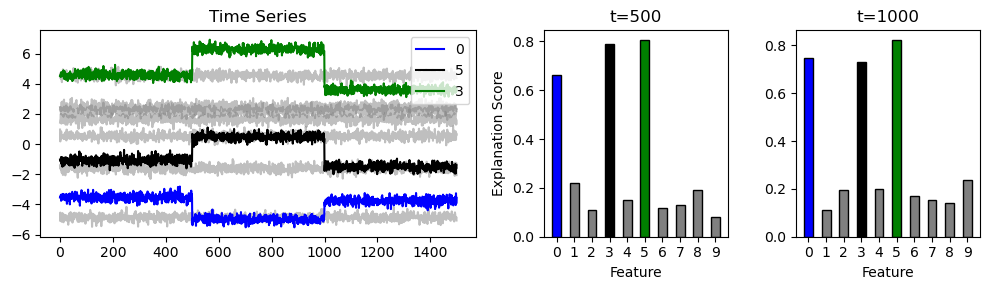

In [13]:

Contributions_plot = np.vstack(detector.exp_data[0][1]).mean(axis=0)
for data in zip(detector.exp_data[0][0],detector.exp_data[0][1]):
    d,c = data[0], data[1]
    Contributions_plot[d['removed_feature']] = c[d['removed_feature']]

print(Contributions_plot)

fig = plt.figure(figsize=(10,3))
gs = GridSpec(1,4)
ax1 = fig.add_subplot(gs[0, :2])
ax1.set_title('Time Series')
#pd.DataFrame(X).iloc[:,varying_features].plot(ax=ax1,color=['blue','black','green'])
columns_to_select = [i for i in range(X.shape[1]) if i not in varying_features]
pd.DataFrame(X).iloc[:,columns_to_select].plot(ax=ax1,color='gray',alpha=0.5,legend=False)
pd.DataFrame(X).iloc[:,varying_features].plot(ax=ax1,color=['blue','black','green'])



Contributions_plot = np.vstack(detector.exp_data[0][1]).mean(axis=0)
for data in zip(detector.exp_data[0][0],detector.exp_data[0][1]):
    d,c = data[0], data[1]
    Contributions_plot[d['removed_feature']] = c[d['removed_feature']]

print(Contributions_plot)

# color_bars = []
# color_bars = [
#     'blue' if i in varying_features else 'gray' 
#     for i in range(Contributions_plot.shape[0])
# ]
c =0
color_bars = []
color_drifts = ['blue','black','green']
for i in range(Contributions_plot.shape[0]):
    if i in varying_features:
        color_bars.append(color_drifts[c])
        c+=1
    else:
        color_bars.append('gray')

print(color_bars)

ax2 = fig.add_subplot(gs[0, 2])

# Plot the bar chart
ax2.bar(
    x=pd.DataFrame(Contributions_plot).index,
    height=pd.DataFrame(Contributions_plot)[0],
    width = 0.5,
    color=color_bars,
    edgecolor='black'
)
ax2.set_xticks(range(X.shape[1]));
ax2.set_ylabel('Explanation Score')
ax2.set_xlabel('Feature')
ax2.set_title('t=500')

ax3 = fig.add_subplot(gs[0, 3])
ax3.set_xlabel('Feature')
ax3.set_title('t=1000')


Contributions_plot = np.vstack(detector.exp_data[1][1]).mean(axis=0)
for data in zip(detector.exp_data[1][0],detector.exp_data[1][1]):
    d,c = data[0], data[1]
    Contributions_plot[d['removed_feature']] = c[d['removed_feature']]

print(Contributions_plot)

c =0
color_bars = []
color_drifts = ['blue','black','green']
for i in range(Contributions_plot.shape[0]):
    if i in varying_features:
        color_bars.append(color_drifts[c])
        c+=1
    else:
        color_bars.append('gray')

# Plot the bar chart
ax3.bar(
    x=pd.DataFrame(Contributions_plot).index,
    height=pd.DataFrame(Contributions_plot)[0],
    width = 0.5,
    color=color_bars,
    edgecolor='black'
)
ax3.set_xticks(range(X.shape[1]));
fig.tight_layout()

In [14]:
fig.savefig('Syn_explanation_plotCPD_horizontal.pdf')